### 0 Load libraries

In [26]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys, os
import osmnx as ox
import networkx as nx
from shapely.geometry import Point

In [98]:
import time
import multiprocessing
from joblib import Parallel, delayed

In [118]:
multiprocessing.cpu_count()

8

### 1 Load parcel buffers and change its CRS

In [44]:
parcel_buffer = gpd.read_file('/Users/su/Desktop/Research/GSD_RA/LDT/02_data/parcel/parcel_centroid_buffer_6346.geojson')[['UNIQUEID', 'X', 'Y', 'geometry']]

In [45]:
parcel_buffer_4326 = parcel_buffer.to_crs(4326)

In [46]:
parcel_buffer_4326

,UNIQUEID,X,Y,geometry
0,4888407_40.4680212651577,-79.910724,40.468021,"MULTIPOLYGON (((-79.89893 40.46791, -79.89955 ..."
1,4888408_40.4357245082487,-80.024640,40.435725,"MULTIPOLYGON (((-80.01285 40.43562, -80.01347 ..."
2,4888412_40.478541348714,-79.953998,40.478541,"MULTIPOLYGON (((-79.94220 40.47843, -79.94282 ..."
3,4888416_40.4549158768041,-79.882681,40.454916,"MULTIPOLYGON (((-79.87089 40.45480, -79.87151 ..."
4,4888422_40.4266880870026,-79.981711,40.426688,"MULTIPOLYGON (((-79.96992 40.42658, -79.97054 ..."
...,...,...,...,...
144180,5468419_40.3895155605449,-79.920191,40.389516,"MULTIPOLYGON (((-79.90841 40.38940, -79.90903 ..."
144181,5468422_40.4007550055504,-79.985343,40.400755,"MULTIPOLYGON (((-79.97356 40.40065, -79.97418 ..."
144182,5468425_40.4608145008291,-79.917927,40.460815,"MULTIPOLYGON (((-79.90613 40.46070, -79.90676 ..."
144183,5468438_40.4174061002107,-80.007634,40.417406,"MULTIPOLYGON (((-79.99585 40.41730, -79.99647 ..."


### 2 Build a function to conduct the network analysis

In [122]:
network_stats = pd.DataFrame(columns=['UNIQUEID', 'X', 'Y', 'circuity_avg', 'streets_per_node_avg', 'intersection_count', 'edge_length_avg'])

##### Option 1: the ordinary for loop

In [123]:
for i in range(0, 5):
        
        parcel_buffer = parcel_buffer_4326.iloc[i]
        buffer_geometry = parcel_buffer['geometry']
        G = ox.graph_from_polygon(buffer_geometry)
        stats = ox.stats.basic_stats(G)
        
        network_stats = network_stats.append({'UNIQUEID': parcel_buffer['UNIQUEID'],
                                              'X': parcel_buffer['X'],
                                              'Y': parcel_buffer['Y'],
                                              'circuity_avg': stats['circuity_avg'],
                                              'streets_per_node_avg': stats['streets_per_node_avg'],
                                              'intersection_count': stats['intersection_count'],
                                              'edge_length_avg': stats['edge_length_avg']}, ignore_index=True)

In [124]:
network_stats

,UNIQUEID,X,Y,circuity_avg,streets_per_node_avg,intersection_count,edge_length_avg
0,4888407_40.4680212651577,-79.910724,40.468021,1.050326,2.993056,491,70.007201
1,4888408_40.4357245082487,-80.024640,40.435725,1.078281,2.815238,431,77.754035
2,4888412_40.478541348714,-79.953998,40.478541,1.065602,2.992079,455,72.845738
3,4888416_40.4549158768041,-79.882681,40.454916,1.037151,3.015190,349,89.132448
4,4888422_40.4266880870026,-79.981711,40.426688,1.076262,3.038168,584,66.513862


In [130]:

network_stats.at[0,'UNIQUEID']= 20

##### 2.2 Option 2: work with parallel computing

In [155]:
network_stats_row = pd.DataFrame(parcel_buffer_4326)[['UNIQUEID', 'X', 'Y']]

In [156]:
network_stats_row['circuity_avg'] = 0.000000
network_stats_row['streets_per_node_avg'] = 0.000000
network_stats_row['intersection_count'] = 0.000000
network_stats_row['edge_length_avg'] = 0.000000

In [162]:
network_stats_row.at[0,'UNIQUEID']= 20

In [163]:
network_stats_row

,UNIQUEID,X,Y,circuity_avg,streets_per_node_avg,intersection_count,edge_length_avg
0,20,-79.910724,40.468021,0.0,0.0,0.0,0.0
1,4888408_40.4357245082487,-80.024640,40.435725,0.0,0.0,0.0,0.0
2,4888412_40.478541348714,-79.953998,40.478541,0.0,0.0,0.0,0.0
3,4888416_40.4549158768041,-79.882681,40.454916,0.0,0.0,0.0,0.0
4,4888422_40.4266880870026,-79.981711,40.426688,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
144180,5468419_40.3895155605449,-79.920191,40.389516,0.0,0.0,0.0,0.0
144181,5468422_40.4007550055504,-79.985343,40.400755,0.0,0.0,0.0,0.0
144182,5468425_40.4608145008291,-79.917927,40.460815,0.0,0.0,0.0,0.0
144183,5468438_40.4174061002107,-80.007634,40.417406,0.0,0.0,0.0,0.0


In [165]:
for i in range(0, 1):
    parcel_buffer = parcel_buffer_4326.iloc[i]
    buffer_geometry = parcel_buffer['geometry']
    G = ox.graph_from_polygon(buffer_geometry)
    stats = ox.stats.basic_stats(G)
    
    network_stats_row.at[i,'circuity_avg']= stats['circuity_avg']
    network_stats_row.at[i,'streets_per_node_avg']= stats['streets_per_node_avg']
    network_stats_row.at[i,'intersection_count']= stats['intersection_count']
    network_stats_row.at[i,'edge_length_avg']= stats['edge_length_avg']

In [166]:
network_stats_row

,UNIQUEID,X,Y,circuity_avg,streets_per_node_avg,intersection_count,edge_length_avg
0,20,-79.910724,40.468021,1.050326,2.993056,491.0,70.007201
1,4888408_40.4357245082487,-80.024640,40.435725,0.000000,0.000000,0.0,0.000000
2,4888412_40.478541348714,-79.953998,40.478541,0.000000,0.000000,0.0,0.000000
3,4888416_40.4549158768041,-79.882681,40.454916,0.000000,0.000000,0.0,0.000000
4,4888422_40.4266880870026,-79.981711,40.426688,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
144180,5468419_40.3895155605449,-79.920191,40.389516,0.000000,0.000000,0.0,0.000000
144181,5468422_40.4007550055504,-79.985343,40.400755,0.000000,0.000000,0.0,0.000000
144182,5468425_40.4608145008291,-79.917927,40.460815,0.000000,0.000000,0.0,0.000000
144183,5468438_40.4174061002107,-80.007634,40.417406,0.000000,0.000000,0.0,0.000000


In [ ]:
def network_statistics(i):
    parcel_buffer = parcel_buffer_4326.iloc[i]
    buffer_geometry = parcel_buffer['geometry']
    G = ox.graph_from_polygon(buffer_geometry)
    stats = ox.stats.basic_stats(G)

    network_stats_row.at[i,'circuity_avg']= stats['circuity_avg']
    network_stats_row.at[i,'streets_per_node_avg']= stats['streets_per_node_avg']
    network_stats_row.at[i,'intersection_count']= stats['intersection_count']
    network_stats_row.at[i,'edge_length_avg']= stats['edge_length_avg']

Parallel(n_jobs=8)(delayed(network_statistics)(i) for i in range(0, 1))

In [189]:
tmp = []

In [194]:
network_stats = pd.DataFrame(columns=['UNIQUEID', 'X', 'Y', 'circuity_avg', 'streets_per_node_avg', 'intersection_count', 'edge_length_avg'])

In [195]:
def network_statistics(i):
    parcel_buffer = parcel_buffer_4326.iloc[i]
    buffer_geometry = parcel_buffer['geometry']
    G = ox.graph_from_polygon(buffer_geometry)
    stats = ox.stats.basic_stats(G)

    global network_stats
    network_stats.append({'UNIQUEID': parcel_buffer['UNIQUEID'],
                                      'X': parcel_buffer['X'],
                                      'Y': parcel_buffer['Y'],
                                      'circuity_avg': stats['circuity_avg'],
                                      'streets_per_node_avg': stats['streets_per_node_avg'],
                                      'intersection_count': stats['intersection_count'],
                                      'edge_length_avg': stats['edge_length_avg']}, ignore_index=True)
    return network_stats


Parallel(n_jobs=8)(delayed(network_statistics)(i) for i in range(0, 1))

[Empty DataFrame
 Columns: [UNIQUEID, X, Y, circuity_avg, streets_per_node_avg, intersection_count, edge_length_avg]
 Index: []]

In [196]:
network_stats

,UNIQUEID,X,Y,circuity_avg,streets_per_node_avg,intersection_count,edge_length_avg


In [197]:
parcel_buffer = parcel_buffer_4326.iloc[1]
parcel_buffer

UNIQUEID                             4888408_40.4357245082487
X                                                   -80.02464
Y                                                   40.435725
geometry    (POLYGON ((-80.0128516127652 40.43562444072955...
Name: 1, dtype: object

In [179]:
network_stats = pd.DataFrame(columns=['UNIQUEID', 'X', 'Y', 'circuity_avg', 'streets_per_node_avg', 'intersection_count', 'edge_length_avg'])

In [180]:
def network_statistics(i):
    
    network_stats = pd.DataFrame(columns=['UNIQUEID', 'X', 'Y', 'circuity_avg', 'streets_per_node_avg', 'intersection_count', 'edge_length_avg'])
    parcel_buffer = parcel_buffer_4326.iloc[i]
    buffer_geometry = parcel_buffer['geometry']
    G = ox.graph_from_polygon(buffer_geometry)
    stats = ox.stats.basic_stats(G)
    
    network_stats.append({'UNIQUEID': parcel_buffer['UNIQUEID'],
                                      'X': parcel_buffer['X'],
                                      'Y': parcel_buffer['Y'],
                                      'circuity_avg': stats['circuity_avg'],
                                      'streets_per_node_avg': stats['streets_per_node_avg'],
                                      'intersection_count': stats['intersection_count'],
                                      'edge_length_avg': stats['edge_length_avg']}, ignore_index=True)
    

In [181]:
network_statistics(2)

In [182]:
network_stats

,UNIQUEID,X,Y,circuity_avg,streets_per_node_avg,intersection_count,edge_length_avg


In [42]:
G = ox.graph_from_polygon(parcel_buffer_4326.iloc[0]['geometry'])

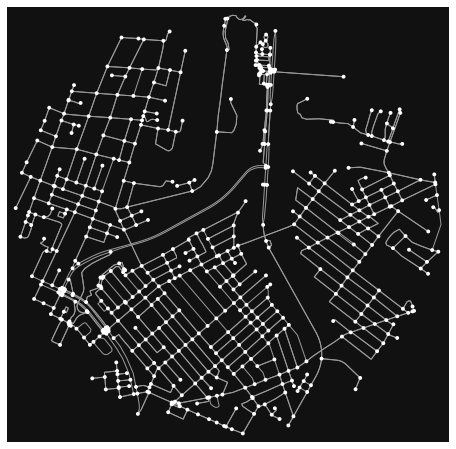

In [49]:
fig, ax = ox.plot_graph(G)

In [50]:
stats = ox.stats.basic_stats(G)

In [17]:
stats['circuity_avg']

1.039516052289444

2.9930555555555554

491

70.00720051249182